# Brain Tumor Image DataSet : Semantic Segmentation
https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/code\
Code from:\
https://www.kaggle.com/code/amrabdellatif/brain-tumor-image-dataset-semantic-segmentation\
https://www.kaggle.com/code/mathieuduverne/brain-segmentation-detectron2-map-50-77-9

---
This dataset seems only got tumor image with two class

In [1]:
from pycocotools.coco import COCO
from PIL import Image
from mat73 import loadmat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json, pickle
import os
import skimage.draw
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2 as cv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# tranform in train might help? Move
# The predict m seems tend to be in the same zone
train_tfm = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the image to 224x224 pixels from the center
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])
test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Crop the image to 224x224 pixels from the center
])

mode = "train"

class Dataset_(Dataset):
    def __init__(self, data):
        self.img = data[0]  # Assuming 'data' is a list of tuples (images, labels)
        self.label = data[1]
        self.tumormask = data[2]

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx], self.tumormask[idx]

## Data

In [2]:
batch_size = 16

In [3]:
# Check data
from torch.utils.data import DataLoader
with open('temp/traindataset.pk', 'rb') as f:
    trainset = pickle.load(f)
with open('temp/validdataset.pk', 'rb') as f:
    validset = pickle.load(f)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

for i, l, m in trainloader:
    print(i.shape)
    break

import gc
gc.collect()

torch.Size([16, 1, 224, 224])


218

## Train and Model

1. Hugging face 
2. Pytorch  `torchvision.models.vit_b_16` [ViT Pretrained](https://pytorch.org/vision/main/models/vision_transformer.html)


Using cache found in /home/jacob/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


torch.Size([1, 224, 224])


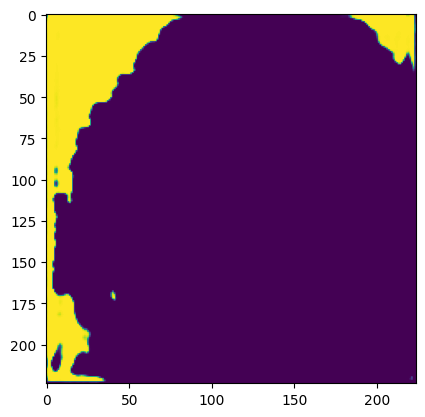

In [4]:
from model import *
for i, l, m in trainloader:
    break
def run():
    model = Pretrain_Unet_Medical(3)
    mask = model(i.to(dtype=torch.float32).cpu())[0]
    print(mask[0].shape)
    plt.imshow(mask[0].cpu().detach().permute(1,2,0))
run()
torch.cuda.empty_cache()

In [5]:
# =======
# Init params
# In Unet already contain res connect
# Here the res means x before conformer add to the last value
from model import *
add_noise_ = False
mix_image_mask = False
model = Pretrain_Unet_Medical(3).to(device)
model_name = model.model_type
print(model_name)
    
init = True
epochs = 10000 # total 
last_epoch = 0
loss_best = 100000
learning_rate = 0.0001
scheduler_per_step = len(trainloader)*50


Pretrain_Unet_Medical


Using cache found in /home/jacob/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


### Folder and Functions

torch.Size([16, 1, 224, 224])


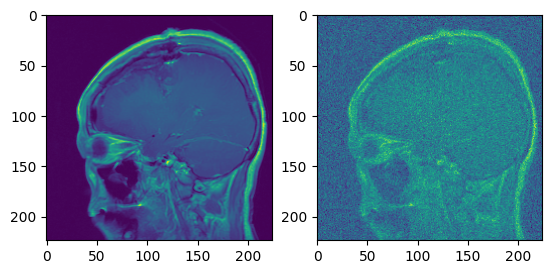

In [6]:
from util import *
noise_image = add_noise(i)
print(noise_image.shape)
plt.subplot(1, 2, 1)
plt.imshow(i[0].cpu().permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(noise_image[0].cpu().permute(1, 2, 0))


In [7]:
print('Models ===================')
directory = 'checkpoint'
if os.path.exists(directory):
    print(f"The directory '{directory}' exists.")
    if os.path.exists(os.path.join(directory, f"{model_name}_best_model.pt")):
        if init: 
            print('Init model')
        else:
            print("load trained model")
            model.load_state_dict(torch.load(f"{directory}/{model_name}_LastTrainModel.pt"))
    else:
        print("Init model")
else:
    print(f"Create '{directory}'.")
    print('Init model')
    os.makedirs(directory, exist_ok=True)   

print('Last trains ==============')
directory = 'epoch'
if os.path.exists(directory):
    print(f"The directory '{directory}' exists.")
    
    if \
        os.path.exists(os.path.join(directory, f"{model_name}_epoch.pk")) and \
        os.path.exists(os.path.join(directory, f"{model_name}_loss_best.pk")) and \
        os.path.exists(os.path.join(directory, f"{model_name}_lr.pk")):
        if init:
            print('Init epoch, loss best, lr')
        else:
            print("load last_epoch, loss_best, learning_rate")
            with open(f"{directory}/{model_name}_epoch.pk", "rb") as f:
                last_epoch = pickle.load(f)
            with open(f"{directory}/{model_name}_loss_best.pk", "rb") as f:
                loss_best = pickle.load(f)
            with open(f"{directory}/{model_name}_lr.pk", "rb") as f:
                learning_rate = pickle.load(f)
    else:
        print('Init epoch, loss best, lr')
else:
    print(f"Create '{directory}'.")
    print('Init epoch, loss best, lr')
    os.makedirs(directory, exist_ok=True)  
    last_epoch = last_epoch
    loss_best = loss_best
    learning_rate = learning_rate

print('Hist of train ============') 
directory = 'result'
if os.path.exists(directory):
    print(f"The directory '{directory}' exists.")
    if os.path.exists(os.path.join(directory, f"{model_name}_hist.pk")):
        if init:
            print('Init hist')
            loss_train = []
            loss_val = []
            acc_val = []
        else:
            print("load hist")
            with open(f"{directory}/{model_name}_hist.pk", "rb") as f:
                hist = pickle.load(f)
            loss_train = hist['loss train']
            loss_val = hist['loss val']
            acc_val = hist['acc val']
    else:
        print('Init hist')
        loss_train = []
        loss_val = []
        acc_val = []
else:
    print(f"Create '{directory}'.")
    print('Init hist')
    os.makedirs(directory, exist_ok=True)
    loss_train = []
    loss_val = []
    acc_val = []    
# =======
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_per_step, gamma=0.9)


Models ===================
The directory 'checkpoint' exists.
Init model
Last trains ==============
The directory 'epoch' exists.
Init epoch, loss best, lr
Hist of train ============
The directory 'result' exists.
Init hist


### Train

In [8]:
stale = 0
for epoch in range(last_epoch, epochs):
    # Train ========
    loss_e = 0
    print("=============")
    model.train()
    for i, l, m in tqdm(trainloader):
        optimizer.zero_grad()
        """
        img, label, mask = i, l, m
        img: ?
        mask: (min, max) = (0, 1)
        """
        # Some process
        """
        img and mask: (min, max) = (0, 255)
        """
        i, l_one, m = process(i, l, m)    
        
        # Mix image and mask
        if epoch < 100 and mix_image_mask:
            i = iamge_with_mask(i, m, max(0.5, (epoch+1)/100))
        
        # Add noise
        if epoch >= 500 and add_noise_:
            for add_time in range(add_times):
                optimizer.zero_grad()
                i = add_noise(i)
                loss, pred_m, out = forward(model, i, l_one, m)
                loss.backward()
                optimizer.step()
                
        # Model, Loss
        """
        In forward: mask/255 to (0, 1)
        In model: MinMaxscaler the output to (0, 1)
        """
        loss, pred_m, out = forward(model, i, l_one, m)
        loss.backward()
        optimizer.step()   
        loss_e += loss.item()
        
        # Scheduler
        if epoch > 100:
            scheduler.step()        
            
    # Validation ========
    with torch.no_grad():
        model.eval()
        pred_m_all = []
        loss_e_val = 0
        acc = 0
        for i, l, m in tqdm(validloader):
            i, l_one, m = process(i, l, m)    
            loss, pred_m, out = forward(model, i, l_one, m)
            loss_e_val += loss.item()
            pred_m_all.append(pred_m)
            acc += (torch.argmax(out, dim=1) == (l-1).reshape(-1)).sum().item()
        if loss_e_val < loss_best:
            stale = 0
            print(f"New best model found in epoch {epoch}, save model!")
            loss_best = loss_e_val
            torch.save(model.state_dict(), f"checkpoint/{model_name}_best_model.pt")    
        else:
            stale += 1
            
        acc = acc/len(validloader.dataset)
        acc_val.append(acc)
        """
        out is not the same but do not change
        """
    torch.save(model.state_dict(), f"checkpoint/{model_name}_LastTrainModel.pt")
    if epoch % 10 == 0:
        pred_m_all = torch.cat(pred_m_all, dim=0)
        save_image(pred_m_all[:25], f"prediction_mask/{model_name}-{epoch}.png")
        
    loss_train.append(loss_e/len(trainloader))
    loss_val.append(loss_e_val/len(validloader))
    print(f"Epoch {epoch} Train loss: {loss_e/len(trainloader)}")
    print(f"Epoch {epoch} Validation acc: {acc}")
    print(f"Epoch {epoch} Validation loss: {loss_e_val/len(validloader)}")    
    
    with open(f"epoch/{model_name}_loss_best.pk", "wb") as f:
        pickle.dump(loss_best, f)
    with open(f"epoch/{model_name}_epoch.pk", "wb") as f:
        pickle.dump(epoch, f)
    with open(f"epoch/{model_name}_lr.pk", "wb") as f:
        pickle.dump(optimizer.param_groups[0]["lr"], f)
    with open(f'result/{model_name}_hist.pk', 'wb') as f:
        pickle.dump({'loss train': loss_train, 'loss val': loss_val, 'acc val': acc_val}, f)
    
    if stale > 100 and epoch > 1000:
        print(f"No improvement in epoch {epoch}, early stop!")
        break

with open(f'result/{model_name}_pred_mask_all.pk', 'wb') as f:
    pickle.dump(pred_m_all, f)

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='val loss')
plt.title(f'{model_name}_loss')
plt.subplot(1, 2, 2)
plt.plot(acc_val, label='train acc')
plt.title(f'{model_name}_acc')
plt.legend()  
plt.show()       
        

100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


Epoch 395 Train loss: 15.228281962407099
Epoch 395 Validation acc: 0.673202614379085
Epoch 395 Validation loss: 115.70769510269164


 42%|████▏     | 65/154 [00:17<00:24,  3.65it/s]

1001


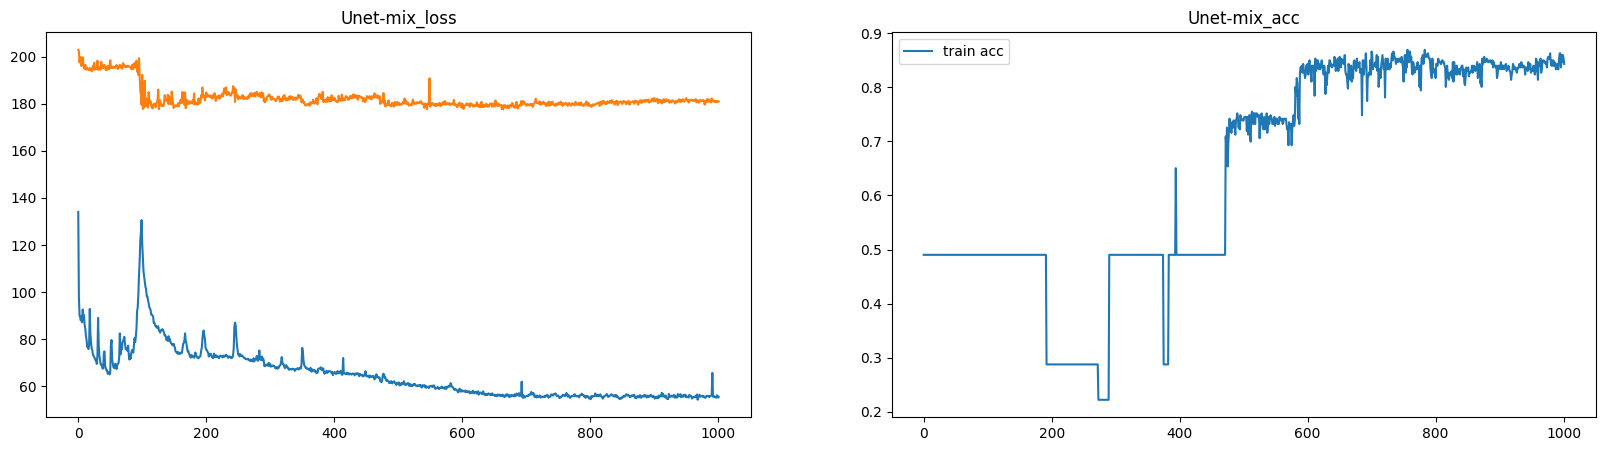

In [ ]:
print(epoch)
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='val loss')
plt.title(f'{model_name}_loss')
plt.subplot(1, 2, 2)
plt.plot(acc_val, label='train acc')
plt.title(f'{model_name}_acc')
plt.legend()
plt.savefig(f'result/{model_name}.png')    
plt.show()


In [ ]:
class BrainDataset(Dataset):

    def __init__(self,
        path,
        ids,
        ims,
        categories,
        segmentations,
        transform = transform,
        files = None,
        type_='train'):
        super(BrainDataset).__init__()
        """
        path = train/ or ...
        """
        self.path = path
        self.type_ = type_
        
        self.files = [os.path.join(path,x) for x in ims]
        if files != None:
            self.files = files
            
        self.ids = ids
        self.categories = categories
        self.segmentations = segmentations       
        
        self.trans = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.trans(im)
        
        id_ = self.ids[idx]
        category = self.categories[idx]
        segmentation = self.segmentations[idx]

        return id_, im, category, segmentation

In [ ]:
train_dataset = BrainDataset("train/", list_id_train, list_im_train, categories_train, list_segmentation_train)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = BrainDataset("valid/", list_id_valid, list_im_valid, categories_valid, list_segmentation_valid)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataset = BrainDataset("test/", list_id_test, list_im_test, categories_test, list_segmentation_test)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

NameError: name 'list_id_train' is not defined

In [ ]:
for loader in [trainloader, testloader, validloader]:
    for id_, im, cat, seg in loader:
        if seg.shape[1] != 1:
            print(id_.shape, im.shape, cat.shape, seg.shape)
print('------')
for id_, im, cat, seg in trainloader:
    print(id_.shape, im.shape, cat.shape, seg.shape)
    break

------
torch.Size([8]) torch.Size([8, 3, 256, 256]) torch.Size([8, 2]) torch.Size([8, 1, 10])
